In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

from skimage.morphology import closing, disk
from tools import *

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


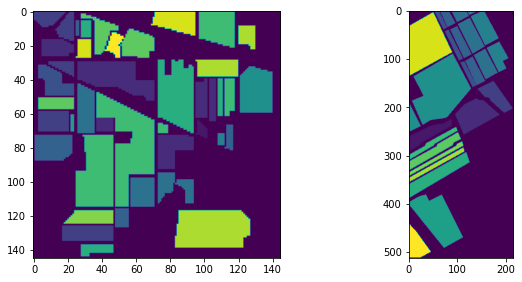

In [36]:
plot_two_figures(indiana_labels, salinas_labels, '', '')

 ## PCA

In [10]:
def get_number_components(X):
    # first PCA with by keeping all features
    print("Fitting the PCA")
    pca_model = PCA()
    pca_model.fit(X)
    var_cumsum = pca_model.explained_variance_ratio_.cumsum()
    return len(var_cumsum[var_cumsum <= 0.9991])

def extract_features(X, n_components):
    pca_model = PCA(n_components=n_components)
    pca_model.fit(X)
    return pca_model.transform(X)

In [11]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [12]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 69
Number of components Salinas: 6


In [13]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [14]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (21025, 69)
Salinas reduced data shape: (111104, 6)


## GMM

In [15]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [16]:
print("Number of labels Indiana: {}".format(n_cluster_indiana))
print("Number of labels Salinas: {}".format(n_cluster_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


In [17]:
indiana_model = GaussianMixture(n_components=n_cluster_indiana, verbose=1)
salinas_model = GaussianMixture(n_components=n_cluster_salinas, verbose=1)

In [18]:
indiana_model.fit(X_indiana_reduced)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [19]:
salinas_model.fit(X_salinas_reduced)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [20]:
indiana_preds = indiana_model.predict(X_indiana_reduced)
salinas_preds = salinas_model.predict(X_salinas_reduced)

In [21]:
indiana_preds = indiana_preds.reshape((indiana_img.shape[0], indiana_img.shape[1]))
salinas_preds = salinas_preds.reshape((salinas_img.shape[0], salinas_img.shape[1]))

In [22]:
final_indiana_preds = remove_unclassified(indiana_preds, indiana_labels)
final_salinas_preds = remove_unclassified(salinas_preds, salinas_labels)

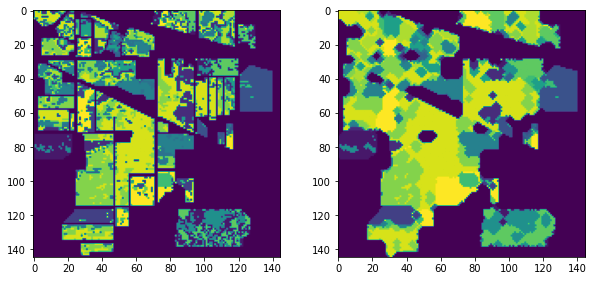

In [50]:
p = closing(final_indiana_preds, disk(2))
plot_two_figures(final_indiana_preds, p, '', '')

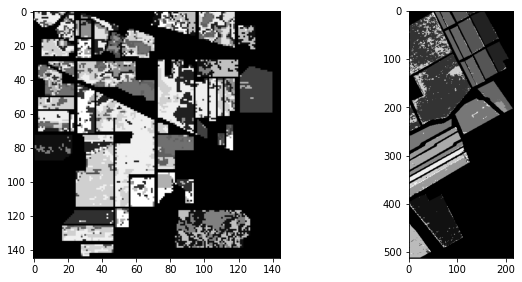

In [26]:
plot_two_figures(final_indiana_preds, final_salinas_preds, '', '', cmap='gray')

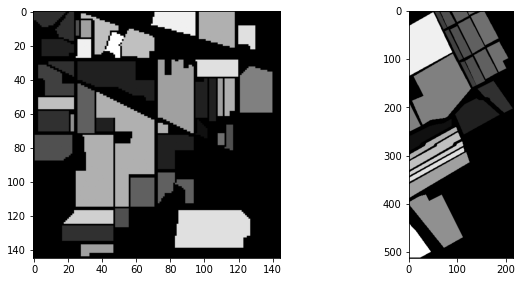

In [9]:
plot_two_figures(indiana_labels, salinas_labels, '', '', cmap='gray')

In [31]:
salinas_labels_flatten = salinas_labels.flatten()
final_preds_flatten = final_salinas_preds.flatten()

test = salinas_labels_flatten[~(salinas_labels_flatten==0)]
test2 = final_preds_flatten[~(final_preds_flatten==0)]

adjusted_rand_score(test, test2)

0.6247010177723425

In [33]:
indiana_labels_flatten = indiana_labels.flatten()
final_preds_flatten = final_indiana_preds.flatten()

test = indiana_labels_flatten[~(indiana_labels_flatten==0)]
test2 = final_preds_flatten[~(final_preds_flatten==0)]

adjusted_rand_score(test, test2)

0.2283841349148872